In [1]:
# My First Kaggle Notebook -- 
# Started Kaggle now but not new to Data Science

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [3]:
from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedKFold, cross_val_score, cross_val_predict
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, log_loss, confusion_matrix

In [4]:
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, StackingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

In [5]:
train = pd.read_csv('/kaggle/input/icr-identify-age-related-conditions/train.csv')
test = pd.read_csv('/kaggle/input/icr-identify-age-related-conditions/test.csv')
greeks = pd.read_csv('/kaggle/input/icr-identify-age-related-conditions/greeks.csv')

In [6]:
train.head()

,Id,AB,AF,AH,AM,AR,AX,AY,AZ,BC,...,FL,FR,FS,GB,GE,GF,GH,GI,GL,Class
0,000ff2bfdfe9,0.209377,3109.03329,85.200147,22.394407,8.138688,0.699861,0.025578,9.812214,5.555634,...,7.298162,1.73855,0.094822,11.339138,72.611063,2003.810319,22.136229,69.834944,0.120343,1
1,007255e47698,0.145282,978.76416,85.200147,36.968889,8.138688,3.632190,0.025578,13.517790,1.229900,...,0.173229,0.49706,0.568932,9.292698,72.611063,27981.562750,29.135430,32.131996,21.978000,0
2,013f2bd269f5,0.470030,2635.10654,85.200147,32.360553,8.138688,6.732840,0.025578,12.824570,1.229900,...,7.709560,0.97556,1.198821,37.077772,88.609437,13676.957810,28.022851,35.192676,0.196941,0
3,043ac50845d5,0.252107,3819.65177,120.201618,77.112203,8.138688,3.685344,0.025578,11.053708,1.229900,...,6.122162,0.49706,0.284466,18.529584,82.416803,2094.262452,39.948656,90.493248,0.155829,0
4,044fb8a146ec,0.380297,3733.04844,85.200147,14.103738,8.138688,3.942255,0.054810,3.396778,102.151980,...,8.153058,48.50134,0.121914,16.408728,146.109943,8524.370502,45.381316,36.262628,0.096614,1


In [7]:
greeks.head()

,Id,Alpha,Beta,Gamma,Delta,Epsilon
0,000ff2bfdfe9,B,C,G,D,3/19/2019
1,007255e47698,A,C,M,B,Unknown
2,013f2bd269f5,A,C,M,B,Unknown
3,043ac50845d5,A,C,M,B,Unknown
4,044fb8a146ec,D,B,F,B,3/25/2020


In [8]:

test

,Id,AB,AF,AH,AM,AR,AX,AY,AZ,BC,...,FI,FL,FR,FS,GB,GE,GF,GH,GI,GL
0,00eed32682bb,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,010ebe33f668,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,02fa521e1838,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,040e15f562a2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,046e85c7cc7f,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
train.describe()

,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,...,FL,FR,FS,GB,GE,GF,GH,GI,GL,Class
count,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,...,616.000000,617.000000,615.000000,617.000000,617.000000,617.000000,617.000000,617.000000,616.000000,617.000000
mean,0.477149,3502.013221,118.624513,38.968552,10.128242,5.545576,0.060320,10.566447,8.053012,5350.388655,...,5.433199,3.533905,0.421501,20.724856,131.714987,14679.595398,31.489716,50.584437,8.530961,0.175041
std,0.468388,2300.322717,127.838950,69.728226,10.518877,2.551696,0.416817,4.350645,65.166943,3021.326641,...,11.496257,50.181948,1.305365,9.991907,144.181524,19352.959387,9.864239,36.266251,10.327010,0.380310
min,0.081187,192.593280,85.200147,3.177522,8.138688,0.699861,0.025578,3.396778,1.229900,1693.624320,...,0.173229,0.497060,0.067730,4.102182,72.611063,13.038894,9.432735,0.897628,0.001129,0.000000
25%,0.252107,2197.345480,85.200147,12.270314,8.138688,4.128294,0.025578,8.129580,1.229900,4155.702870,...,0.173229,0.497060,0.067730,14.036718,72.611063,2798.992584,25.034888,23.011684,0.124392,0.000000
50%,0.354659,3120.318960,85.200147,20.533110,8.138688,5.031912,0.025578,10.461320,1.229900,4997.960730,...,3.028141,1.131000,0.250601,18.771436,72.611063,7838.273610,30.608946,41.007968,0.337827,0.000000
75%,0.559763,4361.637390,113.739540,39.139886,8.138688,6.431634,0.036845,12.969516,5.081244,6035.885700,...,6.238814,1.512060,0.535067,25.608406,127.591671,19035.709240,36.863947,67.931664,21.978000,0.000000
max,6.161666,28688.187660,1910.123198,630.518230,178.943634,38.270880,10.315851,38.971568,1463.693448,53060.599240,...,137.932739,1244.227020,31.365763,135.781294,1497.351958,143790.071200,81.210825,191.194764,21.978000,1.000000


In [10]:
print(train.columns)
print('The number of columns present in Train dataset are ', len(train.columns))

Index(['Id', 'AB', 'AF', 'AH', 'AM', 'AR', 'AX', 'AY', 'AZ', 'BC', 'BD ', 'BN',
       'BP', 'BQ', 'BR', 'BZ', 'CB', 'CC', 'CD ', 'CF', 'CH', 'CL', 'CR', 'CS',
       'CU', 'CW ', 'DA', 'DE', 'DF', 'DH', 'DI', 'DL', 'DN', 'DU', 'DV', 'DY',
       'EB', 'EE', 'EG', 'EH', 'EJ', 'EL', 'EP', 'EU', 'FC', 'FD ', 'FE', 'FI',
       'FL', 'FR', 'FS', 'GB', 'GE', 'GF', 'GH', 'GI', 'GL', 'Class'],
      dtype='object')
The number of columns present in Train dataset are  58


In [11]:
train.rename(columns = {"Class" : "target"}, inplace = True)
train.head()

,Id,AB,AF,AH,AM,AR,AX,AY,AZ,BC,...,FL,FR,FS,GB,GE,GF,GH,GI,GL,target
0,000ff2bfdfe9,0.209377,3109.03329,85.200147,22.394407,8.138688,0.699861,0.025578,9.812214,5.555634,...,7.298162,1.73855,0.094822,11.339138,72.611063,2003.810319,22.136229,69.834944,0.120343,1
1,007255e47698,0.145282,978.76416,85.200147,36.968889,8.138688,3.632190,0.025578,13.517790,1.229900,...,0.173229,0.49706,0.568932,9.292698,72.611063,27981.562750,29.135430,32.131996,21.978000,0
2,013f2bd269f5,0.470030,2635.10654,85.200147,32.360553,8.138688,6.732840,0.025578,12.824570,1.229900,...,7.709560,0.97556,1.198821,37.077772,88.609437,13676.957810,28.022851,35.192676,0.196941,0
3,043ac50845d5,0.252107,3819.65177,120.201618,77.112203,8.138688,3.685344,0.025578,11.053708,1.229900,...,6.122162,0.49706,0.284466,18.529584,82.416803,2094.262452,39.948656,90.493248,0.155829,0
4,044fb8a146ec,0.380297,3733.04844,85.200147,14.103738,8.138688,3.942255,0.054810,3.396778,102.151980,...,8.153058,48.50134,0.121914,16.408728,146.109943,8524.370502,45.381316,36.262628,0.096614,1


In [12]:
print(train.columns)
print('The number of columns present in Train dataset are ', len(train.columns))

Index(['Id', 'AB', 'AF', 'AH', 'AM', 'AR', 'AX', 'AY', 'AZ', 'BC', 'BD ', 'BN',
       'BP', 'BQ', 'BR', 'BZ', 'CB', 'CC', 'CD ', 'CF', 'CH', 'CL', 'CR', 'CS',
       'CU', 'CW ', 'DA', 'DE', 'DF', 'DH', 'DI', 'DL', 'DN', 'DU', 'DV', 'DY',
       'EB', 'EE', 'EG', 'EH', 'EJ', 'EL', 'EP', 'EU', 'FC', 'FD ', 'FE', 'FI',
       'FL', 'FR', 'FS', 'GB', 'GE', 'GF', 'GH', 'GI', 'GL', 'target'],
      dtype='object')
The number of columns present in Train dataset are  58


 AB-GL Fifty-six **anonymized** health characteristics. All are 
numeric except for EJ, which is categorical.
So all these 56 columns are health characteristics


In [13]:
print(train.nunique())

Id        617
AB        217
AF        599
AH        227
AM        605
AR        130
AX        427
AY        148
AZ        484
BC        259
BD        617
BN         53
BP        612
BQ        515
BR        566
BZ        115
CB        553
CC        602
CD        584
CF        586
CH        135
CL        123
CR        595
CS        576
CU        307
CW        426
DA        611
DE        616
DF        137
DH        191
DI        571
DL        604
DN        576
DU        253
DV         39
DY        590
EB        439
EE        513
EG        610
EH        127
EJ          2
EL        311
EP        275
EU        455
FC        600
FD        337
FE        615
FI        498
FL        388
FR        435
FS        161
GB        560
GE        264
GF        611
GH        596
GI        615
GL        355
target      2
dtype: int64


**EJ have only two values so it is categorical**

In [14]:
train.duplicated().sum()

0

**There is no duplicate rows in any cell**

**Make report using Switviz to see its detailed EDA analysis**

In [15]:
#report = sv.analyze(train)
#report.show_html()

# Working with missing values****

In [16]:
contains_missing = ['BQ','CB','CC','DU','EL','FC','FL','FS','GL']

for col in contains_missing :
   mean_value = train[col].mean()
   train[col].fillna(value=mean_value, inplace=True)  # Replace NaN values with the mean value

In [17]:
correlated_data = train.corr()
#print(correlated_data)

/tmp/ipykernel_20/3652691610.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlated_data = train.corr()


<Axes: >

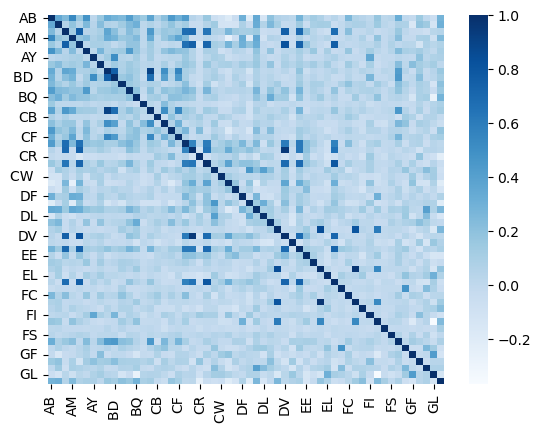

In [18]:
sns.heatmap(data=correlated_data, cmap='Blues', annot=False)

In [19]:
one_hot_encoded = pd.get_dummies(train[['EJ']])
print(one_hot_encoded.head())

   EJ_A  EJ_B
0     0     1
1     1     0
2     0     1
3     0     1
4     0     1


In [20]:
len(one_hot_encoded.columns)

2

In [21]:
for column in one_hot_encoded.columns:
   train.insert(len(train.columns), column , one_hot_encoded.loc[:, column])

In [22]:
train.drop(['EJ', 'Id'], axis=1, inplace=True)

In [23]:
len(train.columns)

58

In [24]:
target_column = train["target"]
train.drop(["target"], inplace=True, axis=1) # Remove target column for training the data
target_column

0      1
1      0
2      0
3      0
4      1
      ..
612    0
613    0
614    0
615    0
616    0
Name: target, Length: 617, dtype: int64

**Our dataset have high variation in data. Ex. look at columns 'AB', 'AH', 'AF', 'AR' and others. So their are lots of descripency and randomness. So we must have to Normalize it**

In [25]:
def standardizationStdScalar(dataset) :
    # Create a StandardScaler object.
    scaler = StandardScaler()
    # Fit and transform the data.
    X_scaled = scaler.fit_transform(dataset)
    X_scaled

In [26]:
def standardizationMinMax(dataset) :
    # Create a StandardScaler object.
    scaler = MinMaxScaler ()
    # Fit and transform the data.
    X_scaled = scaler.fit_transform(dataset)
    X_scaled

In [27]:
#standardizationStdScalar(train)
standardizationStdScalar(train)

In [28]:
# Create the models.
rf_model = RandomForestClassifier()

xgboost_model = XGBClassifier()

svm_model = SVC()

## Cross-Validation 
## GridSearchCV

In [29]:
X, y = train , target_column

<p style= "font-family : verdana ; font-size : 16px ; color : blue" >After performing Grid Search for various hyper parameter it is found that 
 for random forest this is best combination <b>{'max_depth': 6, 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 300}</b> and for XGBoost 
    <b>{'learning_rate': 0.05, 'max_depth': 4, 'min_child_weight': 1, 'n_estimators': 400}</b> this is best combination</p>

In [30]:
# Create the parameter grids for Random Forest and XGBoost
param_grid_rf = {
    "n_estimators": [300] ,           #[100, 200, 300, 400],
    "max_depth": [6] ,              #[3, 4, 5, 6],
    "min_samples_split": [4] ,        #[2, 3, 4],
    "min_samples_leaf":  [2]          #[1, 2, 3],
}

# Create the GridSearchCV objects
grid_search_rf = GridSearchCV(estimator=rf_model, param_grid=param_grid_rf, cv=5)

In [31]:

param_grid_xgb = {
    "learning_rate": [0.05] ,                  #[0.01, 0.05, 0.1],
    "n_estimators": [400] ,                    #[100, 200, 300, 400],
    "max_depth": [4] ,                         #[3, 4, 5, 6],
    "min_child_weight": [1]                    #[1, 2, 3],
}


grid_search_xgb = GridSearchCV(estimator=xgboost_model, param_grid=param_grid_xgb, cv=5)


In [32]:
# Fit the GridSearchCV objects
grid_search_rf.fit(X, y)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [6], 'min_samples_leaf': [2],
                         'min_samples_split': [4], 'n_estimators': [300]})

In [33]:
grid_search_xgb.fit(X, y)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...n=None,
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, ...),
             param_grid={'learning_rate': [0.05], 'max_depth': [4],
                         'min_child_weight': [1], 'n_estimators': [400]})

In [34]:
# Print the best parameters for Random Forest and XGBoost
print(grid_search_rf.best_params_)
print(grid_search_xgb.best_params_)

{'max_depth': 6, 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 300}
{'learning_rate': 0.05, 'max_depth': 4, 'min_child_weight': 1, 'n_estimators': 400}


In [35]:
# Predict on train data

# random forest
predictions_of_rf_on_train = grid_search_rf.predict(X)
accuracy_of_rf_on_train = accuracy_score(predictions_of_rf_on_train , y)
print(accuracy_of_rf_on_train)

0.9789303079416531


**From above score we select XGBoost Model**

In [36]:
# Predict on train data

# xgboost
predictions_of_xgb_on_train = grid_search_xgb.predict(X)
accuracy_of_xgb_on_train = accuracy_score(predictions_of_xgb_on_train , y)
print(accuracy_of_xgb_on_train)

1.0


## LightGBM

In [37]:
lightgbm_params = {
    'objective': ['binary'],
    'metric': ['binary_logloss'],
    'num_leaves': [31],
    'learning_rate': [0.05],
    'feature_fraction': [0.9],
    'bagging_fraction': [0.8],
    'bagging_freq': [5],
    'verbose': [0],
}

In [38]:
lightgbm_model = LGBMClassifier()

In [39]:
lightgbm_model.fit(X, y)

LGBMClassifier()

## Cataboost

In [40]:
    # Create a CatBoostClassifier object
catboost = CatBoostClassifier(n_estimators=100, max_depth=5, learning_rate=0.1)

    # Fit the model to the training data
catboost.fit(X, y)

    # Make predictions on the test data
catboost_predictions = catboost.predict(X)

    # Calculate the accuracy
catboost_accuracy = np.mean(catboost_predictions == y)

0:	learn: 0.5870598	total: 59.5ms	remaining: 5.89s
1:	learn: 0.5196215	total: 64ms	remaining: 3.14s
2:	learn: 0.4855036	total: 68.2ms	remaining: 2.2s
3:	learn: 0.4443184	total: 73ms	remaining: 1.75s
4:	learn: 0.4098061	total: 77.6ms	remaining: 1.47s
5:	learn: 0.3791643	total: 82.1ms	remaining: 1.28s
6:	learn: 0.3499790	total: 86.5ms	remaining: 1.15s
7:	learn: 0.3230230	total: 90.9ms	remaining: 1.04s
8:	learn: 0.3009630	total: 95.3ms	remaining: 964ms
9:	learn: 0.2731942	total: 99.5ms	remaining: 895ms
10:	learn: 0.2517093	total: 104ms	remaining: 839ms
11:	learn: 0.2407662	total: 108ms	remaining: 795ms
12:	learn: 0.2323907	total: 113ms	remaining: 756ms
13:	learn: 0.2185043	total: 118ms	remaining: 724ms
14:	learn: 0.2118263	total: 123ms	remaining: 695ms
15:	learn: 0.2053722	total: 127ms	remaining: 668ms
16:	learn: 0.1983662	total: 132ms	remaining: 644ms
17:	learn: 0.1860751	total: 137ms	remaining: 622ms
18:	learn: 0.1756759	total: 141ms	remaining: 601ms
19:	learn: 0.1696220	total: 147ms	re

In [41]:
print(catboost_accuracy)

1.0


In [42]:
lightgbm_accuracy = accuracy_score(lightgbm_model.predict(X), y)
lightgbm_accuracy

1.0

# Ensemble Learning

In [43]:
param_grid_ensemble = {
    "n_estimators": [200, 300] ,           
    "max_depth": [4, 5] ,           
    "min_samples_split": [3, 4] ,   
    "min_samples_leaf":  [2, 3] ,        
    "learning_rate": [0.01, 0.05],
}


In [44]:
#create a dictionary of our models
estimators=[('xgboost_model', XGBClassifier()), ('rf_model', RandomForestClassifier()), ('catboost_model', CatBoostClassifier()), ('lightgbm_model', LGBMClassifier())]
#create our voting classifier, inputting our models
ensemble = StackingClassifier(estimators)

In [45]:
#fit model to training data
ensemble.fit(X, y)

Learning rate set to 0.008383
0:	learn: 0.6818270	total: 12.3ms	remaining: 12.3s
1:	learn: 0.6753924	total: 19.2ms	remaining: 9.6s
2:	learn: 0.6675429	total: 25.7ms	remaining: 8.55s
3:	learn: 0.6585003	total: 32.5ms	remaining: 8.09s
4:	learn: 0.6517227	total: 39.7ms	remaining: 7.91s
5:	learn: 0.6446493	total: 46.7ms	remaining: 7.74s
6:	learn: 0.6370294	total: 53.7ms	remaining: 7.62s
7:	learn: 0.6280825	total: 60.6ms	remaining: 7.51s
8:	learn: 0.6180914	total: 67.4ms	remaining: 7.42s
9:	learn: 0.6091245	total: 74.1ms	remaining: 7.34s
10:	learn: 0.6032839	total: 80.9ms	remaining: 7.28s
11:	learn: 0.5946718	total: 87.9ms	remaining: 7.24s
12:	learn: 0.5855022	total: 94.7ms	remaining: 7.19s
13:	learn: 0.5777237	total: 101ms	remaining: 7.14s
14:	learn: 0.5718240	total: 108ms	remaining: 7.1s
15:	learn: 0.5655396	total: 115ms	remaining: 7.08s
16:	learn: 0.5601948	total: 122ms	remaining: 7.06s
17:	learn: 0.5523624	total: 129ms	remaining: 7.03s
18:	learn: 0.5464859	total: 136ms	remaining: 7.01s


StackingClassifier(estimators=[('xgboost_model',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric=None,
                                              feature_types=None, gamma=None,
                                              gpu_id=None, grow_policy=None,
                                              importance_type=None,
                                              interaction_constraints=None...
                                              max_delta_step=None,
                                              max_depth=None, max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              n_estimators=100, n_jobs=None,
                                              num_parallel_tree=None,
                                              predictor=None, random_state=None, ...)),
                               ('rf_model', RandomForestClassifier()),
                               ('catboost_model',
                                <catboost.core.CatBoostClassifier object at 0x7cfd1b603250>),
                               ('lightgbm_model', LGBMClassifier())])

In [46]:
ense_pred = ensemble.predict(X)
ense_score = accuracy_score(ense_pred, y)

print(ense_score)

1.0


<p style="color:blue ; font-size : 18px">We have seen that ensemble learnig of XGBoost and Reandom Forest have not made any difference</p>

In [47]:
one_hot_encoded = pd.get_dummies(test[['EJ']])
print(one_hot_encoded.head())

   EJ_A
0     1
1     1
2     1
3     1
4     1


In [48]:
test.fillna(test.mean(), inplace=True)

/tmp/ipykernel_20/2145524900.py:1: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  test.fillna(test.mean(), inplace=True)


In [49]:
test.drop(['EJ', 'Id'], axis=1, inplace=True)

In [50]:
for column in one_hot_encoded.columns:
   test.insert(len(test.columns), column , one_hot_encoded.loc[:, column])

In [51]:
if "EJ_B" not in test.columns:
    test["EJ_B"] = 0
if "EJ_A" not in test.columns:
    test["EJ_A"] = 1

In [52]:
standardizationStdScalar(test)
#standardizationMinMax(test)

In [53]:
predictions = ensemble.predict(test)
predictions

array([0, 0, 0, 0, 0])

In [54]:
y_proba = ensemble.predict_proba(test)
y_proba

array([[0.90717596, 0.09282404],
       [0.90717596, 0.09282404],
       [0.90717596, 0.09282404],
       [0.90717596, 0.09282404],
       [0.90717596, 0.09282404]])

In [55]:
# Calculate the probability for the positive class
positive_class_probability = y_proba[:, 1]

# Calculate the probability for the negative class
negative_class_probability = y_proba[:, 0]

# Print the probabilities
print("Positive class probability:", positive_class_probability)
print("Negative class probability:", negative_class_probability)

Positive class probability: [0.09282404 0.09282404 0.09282404 0.09282404 0.09282404]
Negative class probability: [0.90717596 0.90717596 0.90717596 0.90717596 0.90717596]


In [56]:
test_2 = pd.read_csv('/kaggle/input/icr-identify-age-related-conditions/test.csv')

In [57]:

submissions = pd.DataFrame(
    {"Id": test_2['Id'], "class_0": negative_class_probability, "class_1": 1 - negative_class_probability} 
)

In [58]:
submissions.to_csv("submission.csv", index=False)

In [59]:
pd.read_csv('/kaggle/working/submission.csv').head()

,Id,class_0,class_1
0,00eed32682bb,0.907176,0.092824
1,010ebe33f668,0.907176,0.092824
2,02fa521e1838,0.907176,0.092824
3,040e15f562a2,0.907176,0.092824
4,046e85c7cc7f,0.907176,0.092824
